# Notebook for the IBM Data Science Capstone Project

In [1]:
pip install geopy

     |████████████████████████████████| 102kB 1.0MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geocoder

     |████████████████████████████████| 102kB 935kB/s ta 0:00:01
     |████████████████████████████████| 829kB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 81kB 16.6MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install bs4

     |████████████████████████████████| 102kB 996kB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lxml

     |████████████████████████████████| 5.8MB 953kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mlxtend

     |████████████████████████████████| 1.3MB 917kB/s eta 0:00:01
     |████████████████████████████████| 6.7MB 66kB/s eta 0:00:0101
     |████████████████████████████████| 20.4MB 28.6MB/s eta 0:00:01
     |████████████████████████████████| 25.2MB 31.4MB/s eta 0:00:01
     |████████████████████████████████| 286kB 32.0MB/s eta 0:00:01
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0
  Found existing installation: scikit-learn 0.20.1
    Uninstalling scikit-learn-0.20.1:
      Successfully uninstalled scikit-learn-0.20.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import folium # map rendering library
import urllib.request
from bs4 import BeautifulSoup

import geocoder
from mlxtend.plotting import plot_decision_regions

print('Import done')

Import done


## Index
### Part 1 - Select US city
#### 1.1 Download list of US cities
#### 1.2 1st selection of US cities
#### 1.3 Selection of the top5 US cities
### Part 2 - Find the right neighborhood
#### 2.1 Zip codes for the top5 US cities
#### 2.2 Venues for each zip code using Foursquare.com
#### 2.3 Analysis of the Neighborhoods

# Part1 - Select US city

## 1.1 Download list of US cities

In [7]:
# URL/web page to be scraped to get ZIP codes of Canada
url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
    
# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

soup_city_list = BeautifulSoup(page, "lxml")
right_table_city_list=soup_city_list.find('table', class_='wikitable sortable')

In [8]:
Num=[]
City=[]
est2018=[]
cen2010=[]
Change=[]
Area=[]
PopDensity=[]
#Location=[]

for row in right_table_city_list.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==11:
        Num.append(cells[0].find(text=True))
        City.append(cells[1].find(text=True))
        est2018.append(cells[3].find(text=True))
        cen2010.append(cells[4].find(text=True))
        Change.append(cells[5].find(text=True))
        Area.append(cells[7].find(text=True))
        PopDensity.append(cells[9].find(text=True))
        #Location.append(cells[10].find(text=True))
        
city_list = pd.DataFrame({'Num': Num, 'City': City, '2018 estimate': est2018, '2010 census': cen2010, 'Change [%]': Change, 'Area [km^2]': Area, 'Pop. Density [/km^2]': PopDensity})
city_list = city_list.replace('/km','', regex=True)
city_list = city_list.replace('\xa0km','', regex=True)
city_list = city_list.replace('\n','', regex=True)
city_list = city_list.replace('%','', regex=True)

city_list.head()

,Num,City,2018 estimate,2010 census,Change [%],Area [km^2],Pop. Density [/km^2]
0,1,New York,"8,398,748","8,175,133",+2.74,780.9,"10,933"
1,2,Los Angeles,"3,990,456","3,792,621",+5.22,"1,213.9","3,276"
2,3,Chicago,"2,705,994","2,695,598",+0.39,588.7,"4,600"
3,4,Houston,"2,325,502","2,100,263",+10.72,"1,651.1","1,395"
4,5,Phoenix,"1,660,272","1,445,632",+14.85,"1,340.6","1,200"


### Convert population numbers to integer

In [9]:
for cnt in city_list['Num']:
    chk = int(cnt)-1
    city_list['2010 census'][chk] = city_list['2010 census'][chk].replace(',', '')
    city_list['2018 estimate'][chk] = city_list['2018 estimate'][chk].replace(',', '')

city_list['2010 census'] = city_list['2010 census'].astype(int)
city_list['2018 estimate'] = city_list['2018 estimate'].astype(int)

city_list.head()

,Num,City,2018 estimate,2010 census,Change [%],Area [km^2],Pop. Density [/km^2]
0,1,New York,8398748,8175133,+2.74,780.9,"10,933"
1,2,Los Angeles,3990456,3792621,+5.22,"1,213.9","3,276"
2,3,Chicago,2705994,2695598,+0.39,588.7,"4,600"
3,4,Houston,2325502,2100263,+10.72,"1,651.1","1,395"
4,5,Phoenix,1660272,1445632,+14.85,"1,340.6","1,200"


## 1.2 Conduct a first selection of US cities based on total population and population growth

### Select cities with a population larger that 500,000, convert column 'Change [%]' to float and sort in descending order

In [10]:
city_preselect = city_list.loc[city_list['2018 estimate'] > 500000].copy()

for i in range(len(city_preselect)):
    if city_preselect['Change [%]'][i][0] == '+':
        city_preselect.loc[[i],['Change [%]']] = city_preselect['Change [%]'][i][1:]
    else:
        city_preselect.loc[[i],['Change [%]']] = '-'+city_preselect['Change [%]'][i][1:]

city_preselect['Change [%]'] = city_preselect['Change [%]'].astype(float)

city_preselect.sort_values(['Change [%]'], ascending=False, inplace=True)
city_preselect.reset_index(drop=True)

,Num,City,2018 estimate,2010 census,Change [%],Area [km^2],Pop. Density [/km^2]
0,18,Seattle,744955,608660,22.39,217.0,"3,245"
1,11,Austin,964254,790390,22.00,809.9,"1,170"
2,13,Fort Worth,895008,741206,20.75,888.1,962
3,19,Denver,716492,600158,19.38,397.0,"1,746"
4,16,Charlotte,872498,731424,19.29,791.0,"1,064"
5,20,Washington,702455,601723,16.74,158.2,"4,304"
6,35,Mesa,508958,439041,15.92,357.2,"1,357"
7,7,San Antonio,1532233,1327407,15.43,"1,194.0","1,250"
8,5,Phoenix,1660272,1445632,14.85,"1,340.6","1,200"
9,14,Columbus,892533,787033,13.40,565.9,"1,520"


### Append the coordinates of each city

In [11]:
# add latitude and longitude to pandas dataframe
city_preselect['Latitude'] = np.nan
city_preselect['Longitude'] = np.nan
cnt = 10

for i in range(len(city_preselect)):
    lat_lng_coords = None
    # loop until you get the coordinates
    Name = city_preselect['City'][i]
    while(lat_lng_coords is None):

        g = geocoder.arcgis(Name)
        lat_lng_coords = g.latlng
        city_preselect.loc[[i],['Latitude']] = lat_lng_coords[0]
        city_preselect.loc[[i],['Longitude']] = lat_lng_coords[1]
        #city_preselect.assign(Latitude = lat_lng_coords[0])
        #city_preselect.assign(Longitude = lat_lng_coords[1])
        
        # Progress checker for every ten updated entries
        if i % cnt == 0:
            print('Coordinates appended for',i,'of',len(city_preselect),'entries')        

city_preselect.reset_index(drop=True)
city_preselect.head(len(city_preselect))

Coordinates appended for 0 of 36 entries
Coordinates appended for 10 of 36 entries
Coordinates appended for 20 of 36 entries
Coordinates appended for 30 of 36 entries


,Num,City,2018 estimate,2010 census,Change [%],Area [km^2],Pop. Density [/km^2],Latitude,Longitude
17,18,Seattle,744955,608660,22.39,217.0,"3,245",47.60357,-122.32945
10,11,Austin,964254,790390,22.00,809.9,"1,170",30.26759,-97.74299
12,13,Fort Worth,895008,741206,20.75,888.1,962,32.75095,-97.33086
18,19,Denver,716492,600158,19.38,397.0,"1,746",39.74001,-104.99202
15,16,Charlotte,872498,731424,19.29,791.0,"1,064",35.22286,-80.83796
19,20,Washington,702455,601723,16.74,158.2,"4,304",38.89037,-77.03196
34,35,Mesa,508958,439041,15.92,357.2,"1,357",33.41704,-111.83146
6,7,San Antonio,1532233,1327407,15.43,"1,194.0","1,250",29.42458,-98.49461
4,5,Phoenix,1660272,1445632,14.85,"1,340.6","1,200",33.44825,-112.07580
13,14,Columbus,892533,787033,13.40,565.9,"1,520",39.96199,-83.00275


## 1.3 Select Top5 cities regarding population growth

In [12]:
cities_selected = city_preselect.iloc[:5].reset_index(drop=True)
cities_selected

,Num,City,2018 estimate,2010 census,Change [%],Area [km^2],Pop. Density [/km^2],Latitude,Longitude
0,18,Seattle,744955,608660,22.39,217.0,"3,245",47.60357,-122.32945
1,11,Austin,964254,790390,22.00,809.9,"1,170",30.26759,-97.74299
2,13,Fort Worth,895008,741206,20.75,888.1,962,32.75095,-97.33086
3,19,Denver,716492,600158,19.38,397.0,"1,746",39.74001,-104.99202
4,16,Charlotte,872498,731424,19.29,791.0,"1,064",35.22286,-80.83796


### Display the selected cities

In [13]:
# create map of US cities using latitude and longitude values
address = 'USA'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_usa = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, city in zip(cities_selected['Latitude'], cities_selected['Longitude'], cities_selected['City']):
#for lat, lng, city in zip(sel3['Latitude'], sel3['Longitude'], sel3['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)
    
map_usa

# Part2 - Choice of the right neighborhood (and subsequently the city)

## 2.1 Zip codes for the top5 US cities

### Load csv-file with US zip codes

In [14]:
postal_code_csv = pd.read_csv('zip_code_database.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude'])
postal_code_csv['zip'] = postal_code_csv['zip'].fillna(0)
postal_code_csv['zip'] = postal_code_csv['zip'].astype(int)

postal_code_csv.head()

,zip,type,primary_city,state,latitude,longitude
0,501,UNIQUE,Holtsville,NY,40.81,-73.04
1,544,UNIQUE,Holtsville,NY,40.81,-73.04
2,601,STANDARD,Adjuntas,PR,18.16,-66.72
3,602,STANDARD,Aguada,PR,18.38,-67.18
4,603,STANDARD,Aguadilla,PR,18.43,-67.15


### Select zip codes for the top5 cities, clean the set (cities with same name but in different US states) and get more accurate coordinates (-> geocoder)

#### COMMENT: To save time, I have written the dataframe including the updated coordinates into a csv-file for each of the cities and use them in the following. The following lines of code are, therefore, converted to 'Markdown' after the files have been written.

for i in range(len(cities_selected)):

    print('Starting for:', cities_selected['City'][i])
    postal_code_city = postal_code_csv.loc[postal_code_csv['primary_city'] == cities_selected['City'][i]]
    mode_chk = postal_code_city['state'].mode()
    postal_code_city = postal_code_city.loc[postal_code_city['state'] == mode_chk[0]]
    postal_code_city = postal_code_city.loc[postal_code_city['type'] == 'STANDARD']
    postal_code_city = postal_code_city.reset_index(drop=True)
    
    for j in range(postal_code_city.shape[0]):
        lat_lng_coords = None
        postal_code = str(postal_code_city['zip'][j])
        # loop until you get the coordinates
        while(lat_lng_coords is None):
            g = geocoder.arcgis('{'+postal_code+'} ,'+postal_code_city['primary_city'][j]+', '+postal_code_city['state'][j])
            lat_lng_coords = g.latlng
            postal_code_city['latitude'][j] = lat_lng_coords[0]
            postal_code_city['longitude'][j] = lat_lng_coords[1]

            # Progress checker for every ten updated entries
            if j % cnt == 0:
                print('Coordinates appended for',j,'of',postal_code_city.shape[0],'entries') 

    postal_code_city.to_csv(cities_selected['City'][i]+'_PostalCodeInformation.csv', sep=',')
    print(cities_selected['City'][i]+'_PostalCodeInformation.csv printed')

    print(postal_code_city.head())
    print(postal_code_city['type'].value_counts())

## 2.2 Venues (Movie Theaters, Coffee Shops, Bars) for each zip code using Foursquare.com

In [15]:
secrets = json.load(open('secrets.json'))
CLIENT_ID = secrets['CLIENT_ID']
CLIENT_SECRET = secrets['CLIENT_SECRET']
VERSION = secrets['VERSION']

#### COMMENT: Due to the limited number of daily calls through my Foursquare account I have written the foursquare results into a csv-file for each of the cities and use them in the following. The following lines of code are, therefore, converted to 'Markdown' after the files have been written.

rad = 1000
lim = 100

for i in range(len(cities_selected)):   # through the cities
    
    postal_code_city = pd.read_csv(cities_selected['City'][i]+'_PostalCodeInformation.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude'])
    print(cities_selected['City'][i]+'_PostalCodeInformation.csv loaded')
    postal_code_city['Movie Theaters'] = ""
    postal_code_city['Coffee Shops'] = ""
    postal_code_city['Bars'] = ""
    
    for j in range(postal_code_city.shape[0]):   # through the zip codes
        latitude = postal_code_city['latitude'][j]
        longitude = postal_code_city['longitude'][j]
        
        for k in range(3):   # through the categories
            if k == 0:
                #search_id = '4bf58dd8d48988d17f941735' -> Movie Theater
                search_id = '4bf58dd8d48988d17f941735'
            elif k == 1:
                #search_id = '4bf58dd8d48988d1e0931735' -> Coffee Shops
                search_id = '4bf58dd8d48988d1e0931735'
            elif k == 2:
                #search_id = '4bf58dd8d48988d116941735 -> Bars
                search_id = '4bf58dd8d48988d116941735'
            url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                search_id, CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, rad, lim)
            
            results = requests.get(url).json()

            # assign relevant part of JSON to venues
            venues = results['response']['venues']

            # transform venues into a dataframe
            dataframe = json_normalize(venues)

            if k == 0:
                postal_code_city['Movie Theaters'][j] = dataframe.shape[0]
            elif k == 1:
                postal_code_city['Coffee Shops'][j] = dataframe.shape[0]
            elif k == 2:
                postal_code_city['Bars'][j] = dataframe.shape[0]
            
        # Progress checker for every ten updated entries
        if j % cnt == 0:
            print('Coordinates appended for',j,'of',postal_code_city.shape[0],'entries') 
            
    postal_code_city.to_csv(cities_selected['City'][i]+'_VenueInformation.csv', sep=',')
    print(cities_selected['City'][i]+'_VenueInformation.csv printed')

### Extract population for each zip code

#### COMMENT: To save time, I have written the dataframe including the updated popualtion into a csv-file for each of the cities and use them in the following. The following lines of code are, therefore, converted to 'Markdown' after the files have been written.

for city_chk in range(len(cities_selected)):
    
    city_venues = pd.read_csv(cities_selected['City'][city_chk]+'_VenueInformation.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude','Movie Theaters','Coffee Shops','Bars'])
    print(cities_selected['City'][city_chk]+'_VenueInformation.csv loaded')
    city_venues['Population'] = ""
    
    for zip_chk in range(len(city_venues)):
    
        zip2chk = (str(city_venues['zip'][zip_chk]))
        url = 'http://www.city-data.com/zips/'+zip2chk+'.html'
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')

        for br in soup.find_all('b'):
            next_s = br.nextSibling
            cont = br.contents

            if 'Estimated zip code population in 2016:' in cont:
                city_venues['Population'][zip_chk] = next_s
            #if 'Zip code population in 2010:' in cont:
                #print(cont,next_s)
            #if 'Zip code population in 2000:' in cont:
                #print(cont,next_s)
                
            # Progress checker for every ten updated entries
        #if zip_chk % cnt == 0:
        #    print(zip_chk,'of',len(city_venues))
                        
    for i in range(len(city_venues)):
        city_venues['Population'][i] = city_venues['Population'][i].replace(',', '')

    city_venues = city_venues[city_venues['Population'] != '']
    city_venues = city_venues.reset_index(drop=True)
    city_venues['Population'] = city_venues['Population'].astype(int)

    city_venues.to_csv(cities_selected['City'][city_chk]+'_VenueInformation.csv', sep=',')
    print(cities_selected['City'][city_chk]+'_VenueInformation.csv printed')

    city_venues.head()

### Defining an index to evaluate the best-suited zip code area
#### The sum of Coffee Shops and Bars divided by the Movie Theaters gives an idea of the goodness of an area for a new movie theater (more coffee shops and bars -> higher index, fewer movie theaters -> higher index, thus, a higher index reveals the area to be better suited)

## 2.3 Analysis of the Neighborhoods

### Read the venue data for the top5 cities created in the previous step

In [16]:
seattle_venues = pd.read_csv('Seattle_VenueInformation.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude','Movie Theaters','Coffee Shops','Bars'])
seattle_venues['eval_index'] = ""
seattle_venues['eval_index'] = (seattle_venues['Coffee Shops']+seattle_venues['Bars'])/(seattle_venues['Movie Theaters']+1)

austin_venues = pd.read_csv('Austin_VenueInformation.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude','Movie Theaters','Coffee Shops','Bars'])
austin_venues['eval_index'] = ""
austin_venues['eval_index'] = (austin_venues['Coffee Shops']+austin_venues['Bars'])/(austin_venues['Movie Theaters']+1)

fortworth_venues = pd.read_csv('Fort Worth_VenueInformation.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude','Movie Theaters','Coffee Shops','Bars'])
fortworth_venues['eval_index'] = ""
fortworth_venues['eval_index'] = (fortworth_venues['Coffee Shops']+fortworth_venues['Bars'])/(fortworth_venues['Movie Theaters']+1)

denver_venues = pd.read_csv('Denver_VenueInformation.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude','Movie Theaters','Coffee Shops','Bars'])
denver_venues['eval_index'] = ""
denver_venues['eval_index'] = (denver_venues['Coffee Shops']+denver_venues['Bars'])/(denver_venues['Movie Theaters']+1)

charlotte_venues = pd.read_csv('Charlotte_VenueInformation.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude','Movie Theaters','Coffee Shops','Bars'])
charlotte_venues['eval_index'] = ""
charlotte_venues['eval_index'] = (charlotte_venues['Coffee Shops']+charlotte_venues['Bars'])/(charlotte_venues['Movie Theaters']+1)

In [17]:
top_five4df = {'City':[cities_selected['City'][0],cities_selected['City'][1],cities_selected['City'][2],cities_selected['City'][3],cities_selected['City'][4]],
            'Movie Theaters':[sum(seattle_venues['Movie Theaters']),sum(austin_venues['Movie Theaters']),sum(fortworth_venues['Movie Theaters']),sum(denver_venues['Movie Theaters']),sum(charlotte_venues['Movie Theaters'])],
            'Coffee Shops':[sum(seattle_venues['Coffee Shops']),sum(austin_venues['Coffee Shops']),sum(fortworth_venues['Coffee Shops']),sum(denver_venues['Coffee Shops']),sum(charlotte_venues['Coffee Shops'])],
            'Bars':[sum(seattle_venues['Bars']),sum(austin_venues['Bars']),sum(fortworth_venues['Bars']),sum(denver_venues['Bars']),sum(charlotte_venues['Bars'])],
            'Population':[cities_selected['2018 estimate'][0],cities_selected['2018 estimate'][1],cities_selected['2018 estimate'][2],cities_selected['2018 estimate'][3],cities_selected['2018 estimate'][4]]}

top_five = pd.DataFrame(data=top_five4df)
top_five.head()

,City,Movie Theaters,Coffee Shops,Bars,Population
0,Seattle,113,697,705,744955
1,Austin,21,214,251,964254
2,Fort Worth,16,52,202,895008
3,Denver,50,331,563,716492
4,Charlotte,23,102,255,872498


### Getting a representative sample for each city by summing the different venue categories for each city

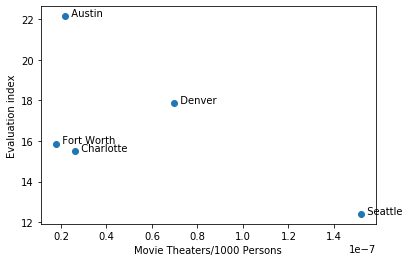

In [18]:
x = top_five['Movie Theaters']/(1000*top_five['Population'])
y = (top_five['Bars']+top_five['Coffee Shops'])/top_five['Movie Theaters']

plt.plot(x,y,'o')
plt.xlabel('Movie Theaters/1000 Persons')
plt.ylabel('Evaluation index')

for ann in range(5):
    plt.annotate('  '+top_five['City'][ann], (x[ann],y[ann]))

### Getting data on the top5 zip code areas in each city regarding their evaluation indices

In [19]:
top_zips4df = {'Zip':[], 'Type':[], 'City':[], 'State':[], 'Latitude':[], 'Longitude':[], 'Movie Theaters':[],'Coffee Shops':[],'Bars':[], 'eval_index':[]}
top_zips = pd.DataFrame(data=top_zips4df, columns=['zip', 'type', 'primary_city', 'state', 'latitude', 'longitude', 'Movie Theaters','Coffee Shops','Bars','Population', 'eval_index'])
tmp=[]

for i in range(len(cities_selected)):   # through the cities
    final_df = pd.read_csv(cities_selected['City'][i]+'_VenueInformation.csv', index_col = False, 
                              usecols = ['zip','type','primary_city','state','latitude','longitude','Movie Theaters','Coffee Shops','Bars','Population'])

    for_eval = final_df
    for_eval['eval_index'] = ""
    for_eval['eval_index'] = (for_eval['Coffee Shops']+for_eval['Bars'])/(for_eval['Movie Theaters']+1)

    for_eval = for_eval.sort_values(['eval_index'], ascending=[False])
    top_zips = top_zips.append(for_eval[0:5]).reset_index(drop=True)
    
top_zips

,zip,type,primary_city,state,latitude,longitude,Movie Theaters,Coffee Shops,Bars,Population,eval_index
0,98188,STANDARD,Seattle,WA,47.44519,-122.28984,0.0,38.0,18.0,25269,56.000000
1,98107,STANDARD,Seattle,WA,47.66951,-122.37919,1.0,29.0,50.0,24525,39.500000
2,98134,STANDARD,Seattle,WA,47.59346,-122.33368,2.0,39.0,50.0,859,29.666667
3,98106,STANDARD,Seattle,WA,47.52462,-122.35845,0.0,8.0,13.0,26216,21.000000
4,98112,STANDARD,Seattle,WA,47.62364,-122.30724,2.0,36.0,19.0,23413,18.333333
5,78702,STANDARD,Austin,TX,30.26352,-97.72638,1.0,17.0,50.0,22941,33.500000
6,78705,STANDARD,Austin,TX,30.29006,-97.74504,1.0,26.0,16.0,32878,21.000000
7,78741,STANDARD,Austin,TX,30.23666,-97.72794,0.0,6.0,9.0,52726,15.000000
8,78734,STANDARD,Austin,TX,30.34850,-97.96376,0.0,5.0,9.0,19269,14.000000
9,78703,STANDARD,Austin,TX,30.27802,-97.75816,1.0,11.0,14.0,21113,12.500000


### Plotting the evaluation index against the movie theater density gives you an idea of which zip code area to choose (the higher the evaluation index and the lower the movie theater density, the better suited)

### Support Vector Machine for confirmation and future purpose

In [20]:
#xfit = [top_zips.loc[:,'Population':'eval_index']]
xfit = top_zips

y2 = (top_zips['Bars']+top_zips['Coffee Shops'])/(top_zips['Movie Theaters']+1)
xfit['deviation'] = (y2-y2.mean())/y2.std()
xfit['goodness'] = ""

for i in range(len(xfit['deviation'])):
    if xfit.loc[i,'deviation'] < 0:
        xfit.loc[i,'goodness'] = 0
    else:
        xfit.loc[i,'goodness'] = 1

feature_df = xfit[['Population', 'eval_index', 'deviation']]
Xb4_train = np.asarray(feature_df)

yb4_train = np.asarray(xfit['goodness']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(Xb4_train, yb4_train, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (20, 3) (20,)
Test set: (5, 3) (5,)


In [21]:
from sklearn import svm
model = svm.SVC(kernel='linear').fit(X_train,y_train)
print(model)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


Text(3.75, 22, 'SVM model')

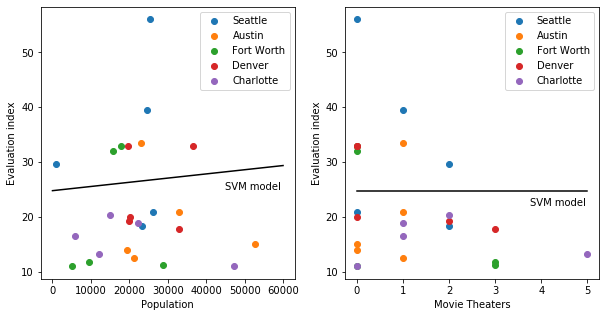

In [22]:
plt.figure(figsize=(10,5))

w = model.coef_[0]
a = -w[0] / w[1]
x_model = np.linspace(0, 60000)
y_model = a * x_model - (model.intercept_[0]) / w[1]

plt.subplot(1, 2, 1)
for i in range(len(top_five)):
    x2 = top_zips['Population'].loc[top_zips['primary_city'] == top_five['City'][i]]
    y2 = top_zips['eval_index'].loc[top_zips['primary_city'] == top_five['City'][i]]
    plt.plot(x2,y2,'o')
    
plt.gca().legend(top_five['City'])
plt.xlabel('Population')
plt.ylabel('Evaluation index')
plt.plot(x_model, y_model, 'k-')
plt.text(45000, 25, 'SVM model')

w = model.coef_[0]
a = -w[0] / w[1]
x_model = np.linspace(0, 5)
y_model = a * x_model - (model.intercept_[0]) / w[1]

plt.subplot(1, 2, 2)
for i in range(len(top_five)):
    x2 = top_zips['Movie Theaters'].loc[top_zips['primary_city'] == top_five['City'][i]]
    y2 = top_zips['eval_index'].loc[top_zips['primary_city'] == top_five['City'][i]]
    plt.plot(x2,y2,'o')

plt.gca().legend(top_five['City'])
plt.xlabel('Movie Theaters')
plt.ylabel('Evaluation index')
plt.plot(x_model, y_model, 'k-')
plt.text(3.75, 22, 'SVM model')

### Create a boxplot of the evaluation index for each selected city for a better overview

(0, 60)

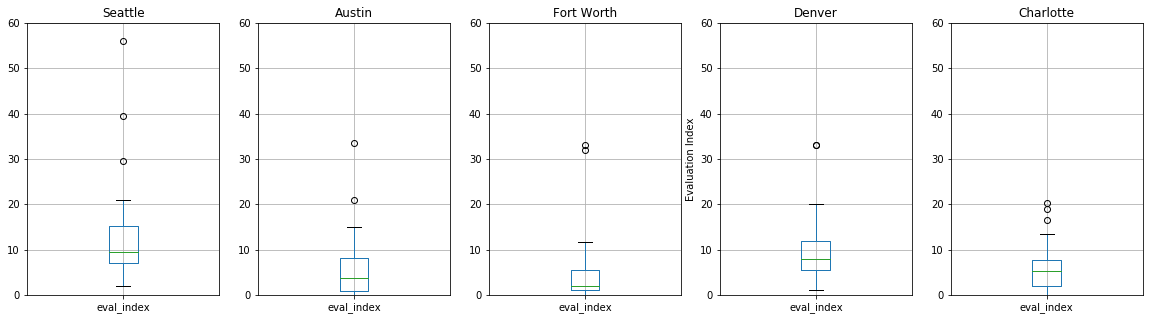

In [23]:
plt.figure(figsize=(20,5))

plt.subplot(1, 5, 1)
boxplot = seattle_venues.boxplot(column=['eval_index'])
plt.title(cities_selected['City'][0])
plt.ylim((0,60))

plt.subplot(1, 5, 2)
boxplot = austin_venues.boxplot(column=['eval_index'])
plt.title(cities_selected['City'][1])
plt.ylim((0,60))

plt.subplot(1, 5, 3)
boxplot = fortworth_venues.boxplot(column=['eval_index'])
plt.title(cities_selected['City'][2])
plt.ylim((0,60))

plt.subplot(1, 5, 4)
boxplot = denver_venues.boxplot(column=['eval_index'])
plt.title(cities_selected['City'][3])
plt.xlabel("")
plt.ylabel("Evaluation Index")
plt.ylim((0,60))

plt.subplot(1, 5, 5)
boxplot = charlotte_venues.boxplot(column=['eval_index'])
plt.title(cities_selected['City'][4])
plt.ylim((0,60))

In [29]:
median = np.median(seattle_venues['eval_index'])
upper_quartile = np.percentile(seattle_venues['eval_index'], 75)
lower_quartile = np.percentile(seattle_venues['eval_index'], 25)
print('Seattle   : Median:',median,'Up. Quartile:',upper_quartile,'Lo. Quartile:',lower_quartile)

median = np.median(austin_venues['eval_index'])
upper_quartile = np.percentile(austin_venues['eval_index'], 75)
lower_quartile = np.percentile(austin_venues['eval_index'], 25)
print('Austin    : Median:',median,'Up. Quartile:',upper_quartile,'Lo. Quartile:',lower_quartile)

median = np.median(fortworth_venues['eval_index'])
upper_quartile = np.percentile(fortworth_venues['eval_index'], 75)
lower_quartile = np.percentile(fortworth_venues['eval_index'], 25)
print('Fort Worth: Median:',median,'Up. Quartile:',upper_quartile,'Lo. Quartile:',lower_quartile)

median = np.median(denver_venues['eval_index'])
upper_quartile = np.percentile(denver_venues['eval_index'], 75)
lower_quartile = np.percentile(denver_venues['eval_index'], 25)
print('Denver    : Median:',median,'Up. Quartile:',upper_quartile,'Lo. Quartile:',lower_quartile)

median = np.median(charlotte_venues['eval_index'])
upper_quartile = np.percentile(charlotte_venues['eval_index'], 75)
lower_quartile = np.percentile(charlotte_venues['eval_index'], 25)
print('Charlotte : Median:',median,'Up. Quartile:',upper_quartile,'Lo. Quartile:',lower_quartile)

Seattle   : Median: 9.566666666666666 Up. Quartile: 15.125 Lo. Quartile: 7.035714285714286
Austin    : Median: 3.75 Up. Quartile: 8.1 Lo. Quartile: 0.875
Fort Worth: Median: 2.0 Up. Quartile: 5.5 Lo. Quartile: 1.0
Denver    : Median: 8.0 Up. Quartile: 11.96875 Lo. Quartile: 5.5
Charlotte : Median: 5.166666666666667 Up. Quartile: 7.708333333333334 Lo. Quartile: 2.0


### Plot a histogram of the frequency of an evaluation index against the evaluation index for each selected city (does not provide significantly more information compared to the boxplot, thus not considered in the report)

(0, 750)

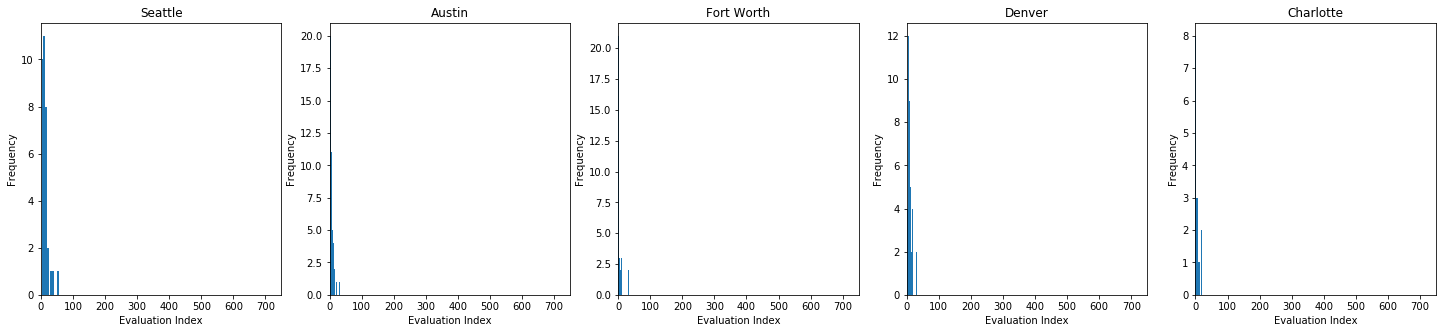

In [30]:
plt.figure(figsize=(25,5))

plt.subplot(1, 5, 1)
plt.hist(seattle_venues['eval_index'])
plt.title(cities_selected['City'][0])
plt.xlabel("Evaluation Index")
plt.ylabel("Frequency")
plt.xlim((0,750))
    
plt.subplot(1, 5, 2)
plt.hist(austin_venues['eval_index'])
plt.title(cities_selected['City'][1])
plt.xlabel("Evaluation Index")
plt.ylabel("Frequency")
plt.xlim((0,750))
    
plt.subplot(1, 5, 3)
plt.hist(fortworth_venues['eval_index'])
plt.title(cities_selected['City'][2])
plt.xlabel("Evaluation Index")
plt.ylabel("Frequency")
plt.xlim((0,750))
        
plt.subplot(1, 5, 4)
plt.hist(denver_venues['eval_index'])
plt.title(cities_selected['City'][3])
plt.xlabel("Evaluation Index")
plt.ylabel("Frequency")
plt.xlim((0,750))
    
plt.subplot(1, 5, 5)
plt.hist(charlotte_venues['eval_index'])
plt.title(cities_selected['City'][4])
plt.xlabel("Evaluation Index")
plt.ylabel("Frequency")
plt.xlim((0,750))

### MAP of the city with the considered zip code coordinates and with a radius propoertional to the evaluation index

In [31]:
# create map of US cities using latitude and longitude values
address = 'Seattle, WA'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_city = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, city, zip_code, eval_indx in zip(top_zips['latitude'], top_zips['longitude'], top_zips['primary_city'], top_zips['zip'], top_zips['eval_index']):
    label = '{}'.format(city,zip_code)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=eval_indx*100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)
    
map_city